In [73]:
import pandas as pd
import numpy as np
import pickle
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_val_score
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'


# data load  and preprocessing

In [17]:
defende_path = "./data/수비/"
batter_path = "./data/타자/"
file_list = ['2011.tsv','2012.tsv','2013.tsv','2014.tsv','2015.tsv','2016.tsv','2017.tsv','2018.tsv','2019.tsv']

In [18]:
def data_load(file_list, defende_path,batter_path):
    df = pd.DataFrame()
    for data_path in file_list:
        defender = pd.read_csv(defende_path + data_path,sep="\t")
        batter = pd.read_csv(batter_path + data_path,sep="\t")
        data = pd.merge(defender,batter,on=["선수명","팀명"])
        df = pd.concat([df,data])
    return df, list(defender.columns)

In [19]:
def del_noise_column(data, columns):
    noise_columns = ["순위_x","순위_y","G_x"] + columns
    for column in noise_columns:
        if column in data:
            del data[column]
    return data

#### defender_coumns 제거를 위해  수비수 포지션을 받고  포지션은 제거 리스트에서 제외

In [20]:
df, defender_coumns = data_load(file_list, defende_path, batter_path)
del defender_coumns[defender_coumns.index("POS")]
del defender_coumns[defender_coumns.index("선수명")]
del defender_coumns[defender_coumns.index("팀명")]

In [21]:
df = del_noise_column(df,list(defender_coumns))

In [22]:
if "선수명" in df:
    df_name = df["선수명"]
    del df["선수명"]

label = None
if "POS" in df:
    label = df["POS"]
    del df["POS"]

In [23]:
del df["팀명"]
# 팀명 원핫 인코딩
# if "팀명" in df:
#     one_hot_encoded = pd.get_dummies(df.팀명) 
#     del df["팀명"]
#     df = pd.concat([one_hot_encoded,df],axis=1)

## 시각화

### 포지션 별 상관 관계

In [42]:
all_data = pd.concat([df, label],axis=1)
all_data.groupby("POS").corr()

G_y        PA        AB         R         H        2B        3B  \
POS                                                                             
1루수 G_y  1.000000  0.922456  0.923767  0.829451  0.885820  0.813824  0.357609   
    PA   0.922456  1.000000  0.996887  0.927286  0.981723  0.909953  0.373524   
    AB   0.923767  0.996887  1.000000  0.915649  0.981412  0.912149  0.372278   
    R    0.829451  0.927286  0.915649  1.000000  0.936551  0.877383  0.426820   
    H    0.885820  0.981723  0.981412  0.936551  1.000000  0.926044  0.371396   
    2B   0.813824  0.909953  0.912149  0.877383  0.926044  1.000000  0.344799   
    3B   0.357609  0.373524  0.372278  0.426820  0.371396  0.344799  1.000000   
    HR   0.660227  0.797870  0.781898  0.876827  0.810451  0.744760  0.224506   
    TB   0.845917  0.961162  0.955539  0.961350  0.977853  0.920291  0.364286   
    RBI  0.804699  0.924726  0.915395  0.932377  0.941682  0.882729  0.300849   
    SAC  0.214951  0.060363  0.061043 -0.019889 -0.011235 -0.040848  0.215582   
    SF   0.636096  0.701770  0.693731  0.651535  0.707117  0.658778  0.296127   
2루수 G_y  1.000000  0.895129  0.895611  0.816662  0.853946  0.792815  0.459240   
    PA   0.895129  1.000000  0.998522  0.934330  0.982333  0.920334  0.553469   
    AB   0.895611  0.998522  1.000000  0.931282  0.984593  0.922617  0.554465   
    R    0.816662  0.934330  0.931282  1.000000  0.950937  0.896615  0.611864   
    H    0.853946  0.982333  0.984593  0.950937  1.000000  0.939629  0.576750   
    2B   0.792815  0.920334  0.922617  0.896615  0.939629  1.000000  0.513855   
    3B   0.459240  0.553469  0.554465  0.611864  0.576750  0.513855  1.000000   
    HR   0.547314  0.660490  0.659285  0.691997  0.673238  0.706916  0.166104   
    TB   0.830383  0.964950  0.966537  0.951394  0.983601  0.955385  0.548274   
    RBI  0.782709  0.905592  0.906385  0.885823  0.919778  0.909421  0.426991   
    SAC  0.526072  0.481838  0.464911  0.330447  0.402722  0.330517  0.198880   
    SF   0.624510  0.726486  0.721917  0.670623  0.725505  0.687911  0.335938   
3루수 G_y  1.000000  0.896233  0.898127  0.837605  0.863599  0.794824  0.438958   
    PA   0.896233  1.000000  0.997873  0.939838  0.985195  0.913751  0.461791   
    AB   0.898127  0.997873  1.000000  0.933824  0.986393  0.917325  0.471066   
    R    0.837605  0.939838  0.933824  1.000000  0.951760  0.885395  0.441759   
    H    0.863599  0.985195  0.986393  0.951760  1.000000  0.929174  0.467586   
    2B   0.794824  0.913751  0.917325  0.885395  0.929174  1.000000  0.399401   
    3B   0.438958  0.461791  0.471066  0.441759  0.467586  0.399401  1.000000   
    HR   0.609936  0.772580  0.757836  0.817203  0.777107  0.725138  0.151660   
    TB   0.827541  0.968066  0.964838  0.958008  0.980517  0.927409  0.413912   
    RBI  0.771583  0.926170  0.918995  0.925546  0.936409  0.878819  0.335886   
    SAC  0.390925  0.279820  0.273163  0.165481  0.215108  0.165170  0.223161   
    SF   0.628240  0.759187  0.753550  0.727506  0.772800  0.715482  0.302533   
유격수 G_y  1.000000  0.898610  0.900324  0.831962  0.869085  0.800148  0.500584   
    PA   0.898610  1.000000  0.998143  0.936386  0.985170  0.917694  0.576033   
    AB   0.900324  0.998143  1.000000  0.932261  0.986513  0.918126  0.581501   
    R    0.831962  0.936386  0.932261  1.000000  0.945422  0.885184  0.570627   
    H    0.869085  0.985170  0.986513  0.945422  1.000000  0.931836  0.565667   
    2B   0.800148  0.917694  0.918126  0.885184  0.931836  1.000000  0.503738   
    3B   0.500584  0.576033  0.581501  0.570627  0.565667  0.503738  1.000000   
    HR   0.529044  0.675578  0.667290  0.770984  0.691511  0.714950  0.288122   
    TB   0.830819  0.963601  0.962596  0.958541  0.978779  0.946424  0.555297   
    RBI  0.775061  0.913453  0.906256  0.930207  0.923832  0.903164  0.478502   
    SAC  0.535068  0.500193  0.484395  0.347192  0.446626  0.351039  0.254008   
    SF   0.617055  0.723676  0.704859  0.6871

### 포지션을 포함하기 위해 원핫 인코딩으로 변형 후 결과

In [53]:
corr_pos = pd.concat([pd.get_dummies(label),df],axis = 1).corr()
corr_pos

,1루수,2루수,3루수,유격수,G_y,PA,AB,R,H,2B,3B,HR,TB,RBI,SAC,SF
1루수,1.000000,-0.333440,-0.332787,-0.287152,0.045864,0.116789,0.116840,0.097005,0.136110,0.143168,-0.055880,0.257983,0.179298,0.221544,-0.211584,0.125987
2루수,-0.333440,1.000000,-0.382944,-0.330431,-0.051688,-0.082330,-0.083503,-0.054241,-0.082295,-0.091282,0.062971,-0.180876,-0.115554,-0.146731,0.086429,-0.099625
3루수,-0.332787,-0.382944,1.000000,-0.329784,-0.016284,-0.011228,-0.009562,-0.016939,-0.014024,-0.001945,-0.062594,0.044808,0.002568,0.017465,-0.042874,0.006588
유격수,-0.287152,-0.330431,-0.329784,1.000000,0.027164,-0.016532,-0.017113,-0.020777,-0.032976,-0.043392,0.055696,-0.112557,-0.058398,-0.083292,0.165656,-0.026320
G_y,0.045864,-0.051688,-0.016284,0.027164,1.000000,0.900531,0.901791,0.827230,0.863939,0.795624,0.432614,0.566931,0.822349,0.761190,0.412251,0.625136
PA,0.116789,-0.082330,-0.011228,-0.016532,0.900531,1.000000,0.997910,0.933963,0.983108,0.915081,0.478976,0.716594,0.958748,0.902739,0.316041,0.731530
AB,0.116840,-0.083503,-0.009562,-0.017113,0.901791,0.997910,1.000000,0.927778,0.984218,0.917267,0.482192,0.706365,0.956634,0.897115,0.305531,0.722766
R,0.097005,-0.054241,-0.016939,-0.020777,0.827230,0.933963,0.927778,1.000000,0.945986,0.886161,0.503810,0.775869,0.951991,0.904008,0.192718,0.686346
H,0.136110,-0.082295,-0.014024,-0.032976,0.863939,0.983108,0.984218,0.945986,1.000000,0.932661,0.479449,0.735553,0.977204,0.921013,0.240974,0.733497
2B,0.143168,-0.091282,-0.001945,-0.043392,0.795624,0.915081,0.917267,0.886161,0.932661,1.000000,0.419456,0.717523,0.936062,0.886397,0.172444,0.694517


### seaborn 을 이용한 상관관계 출력

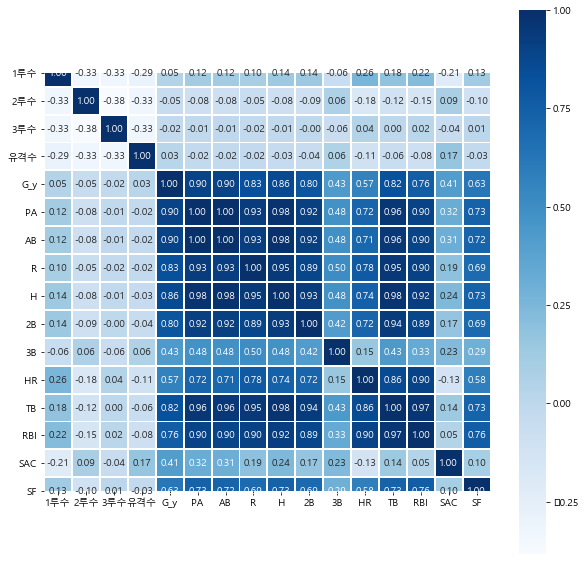

In [88]:
corr_pos
# Set background color / chart style
# sns.set_style(style = 'white')
plt.figure(figsize=(10,10))
sns.heatmap(corr_pos, annot=True,
        square=True,fmt=".2f",
        linewidths=.90,  cmap='Blues')